In [2]:
import numpy as np
import pandas as pd
from collections import defaultdict
from matplotlib import pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

In [3]:
#Download the data

TRAIN_DATA = pd.read_csv('problem_train.csv', index_col=0, low_memory = False)
EXERCISE_DATA = pd.read_csv('problem_test.csv', index_col=0, low_memory = False)
LABELS = pd.read_csv('problem_labels.csv', index_col=0, low_memory = False)

print('TRAIN_DATA:', TRAIN_DATA.shape)
print('EXERCISE_DATA:', EXERCISE_DATA.shape)
print('LABELS:', LABELS.shape)

TRAIN_DATA: (8000, 1378)
EXERCISE_DATA: (2000, 1378)
LABELS: (8000, 14)


In [4]:
# Let's have a look at the data

TRAIN_DATA.head(10)

,release,n_0000,n_0001,n_0002,n_0003,n_0004,n_0005,n_0006,n_0007,n_0008,...,c_1368,c_1369,c_1370,c_1371,c_1372,c_1373,c_1374,c_1375,c_1376,c_1377
id,,,,,,,,,,,,,,,,,,,,,
11193,a,NaN,NaN,0.025449,NaN,NaN,0.368421,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,a,NaN,q,NaN,NaN,NaN
11382,a,NaN,NaN,0.031297,NaN,NaN,0.315789,NaN,NaN,NaN,...,NaN,NaN,a,NaN,a,NaN,NaN,NaN,NaN,NaN
16531,a,NaN,NaN,0.024475,NaN,NaN,0.342105,NaN,NaN,NaN,...,NaN,NaN,a,NaN,a,NaN,b,NaN,NaN,NaN
1896,a,NaN,NaN,0.041694,NaN,NaN,0.447368,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,a,NaN,NaN,NaN,NaN,NaN
18262,c,NaN,NaN,0.038120,NaN,NaN,0.315789,NaN,NaN,NaN,...,NaN,NaN,b,NaN,a,NaN,a,NaN,NaN,NaN
10540,b,NaN,NaN,0.039420,NaN,NaN,0.368421,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,a,NaN,NaN,NaN,NaN,NaN
5244,c,NaN,NaN,0.050141,NaN,NaN,0.394737,0.2,NaN,NaN,...,NaN,NaN,NaN,NaN,a,NaN,NaN,NaN,NaN,NaN
1929,a,NaN,NaN,0.049166,NaN,NaN,0.710526,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,a,NaN,NaN,NaN,NaN,NaN
11928,b,NaN,NaN,0.050249,NaN,NaN,0.394737,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,b,NaN,NaN,NaN,NaN,b


In [5]:
# To study statistics, I combine all the data into one dataset, and also combine the data with the available answers

WHOLE_DATA = pd.concat([TRAIN_DATA,EXERCISE_DATA],axis=0)
DATA_W_LABELS = pd.concat([TRAIN_DATA,LABELS],axis=1)

print('WHOLE_DATA:', WHOLE_DATA.shape)
print('DATA_W_LABELS:', DATA_W_LABELS.shape)

WHOLE_DATA: (10000, 1378)
DATA_W_LABELS: (8000, 1392)


In [6]:
# scikit-learn's VarianceThreshold doesnt work with categorical features, 
# so I remove empty columns and remove columns completely filled with a single value by hand

TRAIN_DATA.dropna(axis='columns', how='all', inplace=True)

EXERCISE_DATA = EXERCISE_DATA[TRAIN_DATA.columns.tolist()]
WHOLE_DATA = WHOLE_DATA[TRAIN_DATA.columns.tolist()]
DATA_W_LABELS = pd.concat([TRAIN_DATA,LABELS],axis=1)

with_1_uniq_value = []
for col in TRAIN_DATA.columns.tolist():
    if len(TRAIN_DATA[col].unique()) == 1 and TRAIN_DATA[col].isna().sum() == 0:
        with_1_uniq_value.append(col)

for data in [TRAIN_DATA, EXERCISE_DATA, WHOLE_DATA, DATA_W_LABELS]:
    data.drop(columns = with_1_uniq_value, inplace=True)
    data.replace('NaN', np.nan)
    
print('TRAIN_DATA:', TRAIN_DATA.shape)
print('EXERCISE_DATA:', EXERCISE_DATA.shape)
print('WHOLE_DATA:', WHOLE_DATA.shape)

TRAIN_DATA: (8000, 1342)
EXERCISE_DATA: (2000, 1342)
WHOLE_DATA: (10000, 1342)


Thus we deleted 30 completely empty columns and 6 useless columns filled completely with a single value.

In [7]:
#Let's divide the dataset columns into 3 categories (according to the first letter of the name) and count the number of columns in each category.

def columns_stat(df: pd.DataFrame):
    columns = df.columns.tolist()
    columns_categories = defaultdict(list)
    for col in columns:
        if col == 'release':
            columns_categories['release'].append(col)
        elif str(col)[0].isalpha():
            columns_categories[col[0]].append(col)
    return columns_categories

def columns_catstat(columns_categories):
    return [(key, len(columns_categories[key])) for key in columns_categories.keys()]

stat = {}
columns_categories = defaultdict(list)
for col in WHOLE_DATA:
    stat[col] = WHOLE_DATA[col].notna().sum()
    columns_categories[col[0]].append(col)
[(key, len(columns_categories[key])) for key in columns_categories.keys()]

[('r', 1), ('n', 109), ('o', 208), ('c', 1024)]

Thus we see that the most of the dataset consists of categorical columns.

## Statistics for missing and unique values

In [8]:
def Occupancy_Cardinality_Plots(data, category, count_unique=False):

    ncols=3 if count_unique else 2
    
    fig, axs = plt.subplots(nrows=1, ncols=ncols, figsize=(5*ncols,5))
    cols = []
    
    for thresh in range(len(data)):
        cols.append(len([col for col in columns_categories[category] if stat[col] >= thresh]))
        
    axs[0].plot(range(len(data)),cols) 
    axs[0].set_title('occupancy rate')
    axs[0].set_xlabel('occupancy')
    axs[0].set_ylabel('# columns')
    axs[0].grid(True)

    df = data[columns_categories[category]]

    cardinality = df.nunique(dropna=False)
    missinig_values = df.isnull().sum()
    feature_stats = pd.DataFrame({'card': cardinality, 'miss': missinig_values})
    axs[1].scatter(feature_stats['card'], feature_stats['miss'], alpha=0.65)
    axs[1].set_title('cardinality vs missing')
    axs[1].set_xlabel('cardinality')
    axs[1].set_ylabel('miss')
    axs[1].grid(True)
 
    if count_unique:
        lenghts = {}
        for col in columns_categories[category]:
            if len(df[col].unique()) in lenghts.keys():
                lenghts[len(df[col].unique())] += 1
            else: 
                lenghts[len(df[col].unique())] = 1
            
        lenghts = dict(sorted(lenghts.items()))
        
        keys = list(lenghts.keys())[0:40]
        vals = list(lenghts.values())[0:40]
        
        axs[2].bar(keys, vals)
        axs[2].set_title('statictics of unique values')
        axs[2].set_xlabel('cardinality')
        axs[2].set_ylabel('# columns')
        axs[2].grid(True)

    plt.show()

As we can see from the following graphs, there are a lot of missing values in the data. 

### Numerical columns

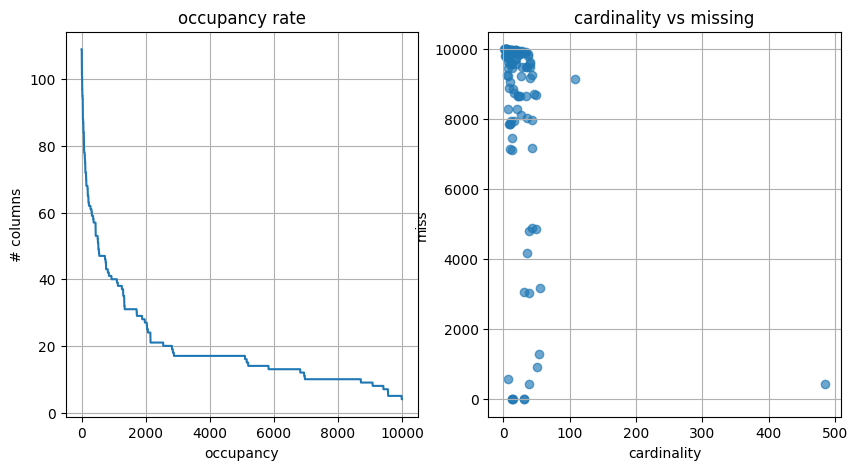

In [9]:
Occupancy_Cardinality_Plots(WHOLE_DATA, 'n')

### Ordinal columns

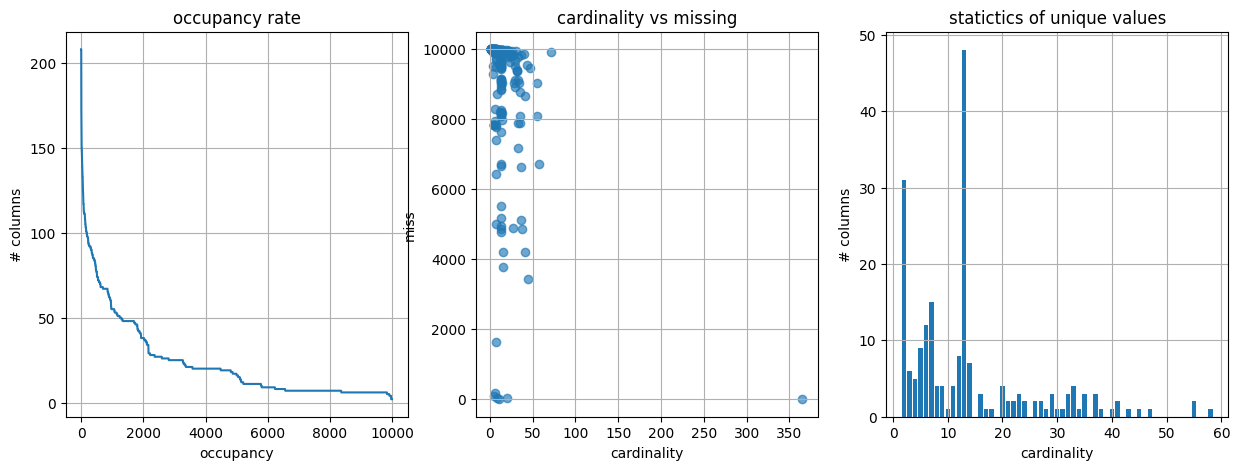

In [10]:
Occupancy_Cardinality_Plots(WHOLE_DATA, 'o', True)

We see that ordinal columns take at least half as many unique values as numerical ones. This makes them closer to categorical. We also see that many ordinal columns take from 2 to 14 unique values. Let's try to apply one-hot-encoding to them, along with categorical columns with the same statistics.

### Categorical columns

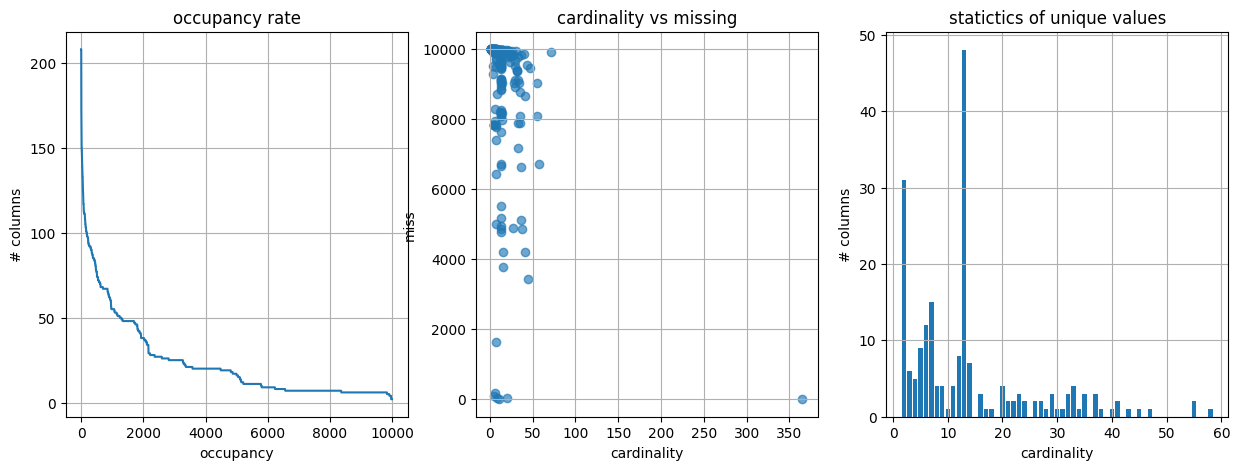

In [11]:
Occupancy_Cardinality_Plots(WHOLE_DATA,'o', True)

Here you can see that the maximum number of unique values for majority of well-fillid columns is slightly more than 30 (in fact, these columns contain lowercase and uppercase letters of the Latin alphabet), and mostly categorical columns contain no more than 10 values (NaN is considered a unique value). I will try to use one-hot encoding for these columns, and will either encode the rest without creating additional columns, or use an embedding, the dimension of which will be also determined by the number of unique values.

## Conclusion:

Overall, we see a similar pattern of occupancy for all three types of columns (1st plots). This is good and means that we can throw out columns by percentage of occupancy for all types simultaneously, expecting to get a balanced dataset. Moreover, such a pattern may indicate that the missing values in the data may not be random (Missing Not at Random or MNAR), and the indication of a missing value can be informative and useful in itself. Therefore, as the simplest way to fill the gaps, I will choose to impute with a constant value, which obviously goes beyond the range of the existing values. Since in our case, the dataset is filled with positive values, we can impute with a large negative value as an indication of a missing value. This a solid choice for "tree-based" ML-algorithms, but I will try other imputation methods as well.

## Release Column & Cyclicity of Data

The "release" column is special. It is filled completely and takes only 3 values: 'A', 'B', 'C'.
As can be seen from the following graphs (the column indicates the number of “1s” in a given target column), “release” reflects some cyclicity in the data, you can see a clear direct correlation for at least half of the target columns. And moreover, as follows from a simple calculation, the ratio of the sum of all units in all target columns to the number of samples in the dateset with a given release is approximately preserved.

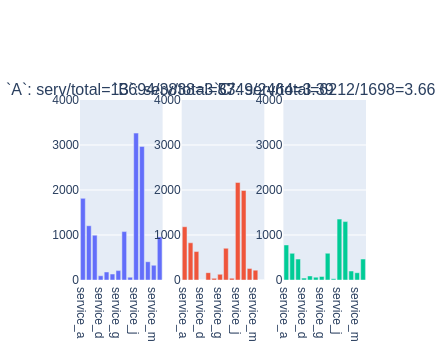

In [15]:
import math 
columns = LABELS.columns.tolist()

total_a = DATA_W_LABELS[DATA_W_LABELS.release == 'a'][columns].sum().values
total_b = DATA_W_LABELS[DATA_W_LABELS.release == 'b'][columns].sum().values
total_c = DATA_W_LABELS[DATA_W_LABELS.release == 'c'][columns].sum().values

a = DATA_W_LABELS[DATA_W_LABELS.release == 'a'].shape[0]
b = DATA_W_LABELS[DATA_W_LABELS.release == 'b'].shape[0]
c = DATA_W_LABELS[DATA_W_LABELS.release == 'c'].shape[0]

def simple_bar_subplots(xs, ys, titles=None, main_title='', cols: int = 2, yaxis=None, height=None, width=None):
    fig = make_subplots(
        rows=math.ceil(len(xs) / cols), cols=cols,
        subplot_titles=titles
    )
    row, col = 1, 1
    for x, y in zip(xs, ys):
        fig.add_trace(go.Bar(x=x, y=y), row=row, col=col)
        fig.update_layout(yaxis_range=yaxis)
        col += 1
        if col > cols:
            row += 1 
            col = 1
    fig.update_layout(
        showlegend=False,
        title_text=main_title,
        height=height, width=width,
    )
    if yaxis:
        fig.update_yaxes(range=yaxis)
    return fig

simple_bar_subplots(
    xs=[columns,columns, columns],
    ys=[total_a, total_b, total_c],
    titles=['`A`: serv/total='+str(total_a.sum())+'/'+str(a)+'='+str(np.round(total_a.sum()/a, 2)),
            '`B`: serv/total='+str(total_b.sum())+'/'+str(b)+'='+str(np.round(total_b.sum()/b, 2)),
            '`C`: serv/total='+str(total_c.sum())+'/'+str(c)+'='+str(np.round(total_c.sum()/c, 2))],
    cols=3,
    yaxis=[0, 4000]
)

We will see later that by using a stratified train-test split with respect to this column and the label columns, we can achieve a significant reduction in error variance.

In [ ]:
# Save the figure locally
fig.write_html("release_analysis.html")

# Show the figure
from IPython.display import HTML
HTML(filename="release_analysis.html")